In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import imageio

In [3]:
#First loading all images into numpy arrays
#Note that this also normalises the data

def load_data():
    X_train=[]
    for f in listdir('train'):
        if f!='.ipynb_checkpoints':
            path='train/'+f
            X_train.append(list(imageio.imread(path)))
    X_train=np.array(X_train)

    X_test=[]
    for f in listdir('test'):
        path='test/'+f
        X_test.append(list(imageio.imread(path)))
    X_test=np.array(X_test)

    X_train = X_train[:,:,:,np.newaxis]
    X_test = X_test[:,:,:,np.newaxis]

    X_train = X_train.astype(float)/255.
    X_test = X_test.astype(float)/255.
    
    return X_train, X_test

X_train, X_test = load_data()

#Sanity check
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)

X_train shape: (9664, 256, 256, 1)
X_test shape: (544, 256, 256, 1)


In [4]:
class VQ(layers.Layer):

#N and K are respectively the number of vectors in the codebook the dimension of the vectors
    def __init__(self,N,K,beta=0.1,**kwargs):
        super().__init__(**kwargs)
        self.N = N
        self.K = K
        self.beta = beta

        #As per the paper, initialising the prior as uniform

        prior = tf.random_uniform_initializer()
        self.codebook = tf.Variable(initial_value=prior((self.K,self.N),dtype="float32"),
                                    trainable=True,name="Codebook")
    
    def call(self,input):

        #Flattening the inputs
        input_shape = tf.shape(input)
        reshape_input = tf.reshape(input,[-1,self.K])

        #Moving on to the quantisation part
        idx = self.get_code_indices(reshape_input)
        #One-hot encoding the inputs first, so as to make it easier to compute.
        #Indeed this well help resort to a simple matrix product later on
        oh_enc = tf.one_hot(idx,self.N)
        #Then quantising and reshaping to the original input shape
        q_enc = tf.reshape(tf.matmul(oh_enc,self.codebook,transpose_b=True),input_shape)

        #Finally computing the loss
        #The below is the third loss term introduced in the paper, the one where beta intervenes
        beta_loss = self.beta*tf.reduce_mean((tf.stop_gradient(q_enc) - input)**2)
        #This one on the other hand is the second term, the one that measures the difference
        #between the encoded vector and the input
        encoding_loss = tf.reduce_mean((q_enc - tf.stop_gradient(input))**2)
        self.add_loss(beta_loss + encoding_loss)

        return input+tf.stop_gradient(q_enc-input)

    def get_code_indices(self,input):
        #Caveat : input needs to be flattened here
        #Here determining the nearest codebook vector to each of the input data points
        sim = tf.matmul(input,self.codebook)
        distances = tf.reduce_sum(input**2,axis=1,keepdims=True)+tf.reduce_sum(self.codebook**2,axis=0) - 2*sim
        #Lastly, need to chuck everything into an argmin to get indices of the codebook vectors each input data point was assigned to
        encoding_indices = tf.argmin(distances,axis=1)
        return encoding_indices

#Now we need to code the encoder and decoder
def encoder(dim=128):
    enc_inputs = keras.Input(shape=(256,256,1))

    x = layers.Conv2D(256, (3,3), activation="relu", strides=1, padding="same")(enc_inputs)
    x = layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    x = layers.Conv2D(128, (3,3), activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    x = layers.Conv2D(64, (3,3), activation="relu", strides=1, padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    enc_outputs = layers.Conv2D(dim,(3,3),padding='same')(x)

    return keras.Model(enc_inputs,enc_outputs,name='encoder')

def decoder(dim=128):
    latents = keras.Input(shape=encoder().output.shape[1:])
    x = layers.Conv2DTranspose(64,(3,3),activation='relu',strides=(2,2),padding='same')(latents)
    x = layers.Conv2DTranspose(128,(3,3),activation='relu',strides=(2,2),padding='same')(x)
    x = layers.Conv2DTranspose(256,(3,3),activation='relu',strides=(2,2),padding='same')(x)
    decoded = layers.Conv2DTranspose(1,3,padding='same')(x)
    return keras.Model(latents,decoded,name='decoder')

#Assembling all of the above to build the VQVAE
def vqvae(dim=128,N=512):

    vq = VQ(N,dim,name='Quantiser')
    enc = encoder(dim)
    dec = decoder(dim)
  
    input = keras.Input(shape=(256,256,1))
    output = enc(input)
    ql = vq(output)
  
    reconstructed = dec(ql)
    return keras.Model(input,reconstructed,name='VQVAE')

vqvae().summary()

Model: "VQVAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder (Functional)         (None, 32, 32, 128)       445248    
_________________________________________________________________
Quantiser (VQ)               (None, 32, 32, 128)       65536     
_________________________________________________________________
decoder (Functional)         (None, 256, 256, 1)       445121    
Total params: 955,905
Trainable params: 955,905
Non-trainable params: 0
_________________________________________________________________


In [6]:
#On to the training module

class vqvae_trainer(keras.models.Model):

    def __init__(self,var,dim=128,N=512,**kwargs):
        super(vqvae_trainer,self).__init__(**kwargs)
        self.var = var
        self.dim = dim
        self.N = N
        self.vq_vae = vqvae(self.dim,self.N)

        #Tracking the losses
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.vq_loss_tracker = keras.metrics.Mean(name='vq_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.vq_loss_tracker]

    def train_step(self,input):
        with tf.GradientTape() as gt:
            reconstructions = self.vq_vae(input)
            reconstruction_loss = (tf.reduce_mean((input - reconstructions) ** 2) / self.var)
            total_loss = reconstruction_loss + sum(self.vq_vae.losses)
    
        #Time to backprop
        gradients = gt.gradient(total_loss,self.vq_vae.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.vq_vae.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vq_vae.losses))

        return {"Total_loss": self.total_loss_tracker.result(),
              "reconstruction_loss": self.reconstruction_loss_tracker.result(),
              "VQVAE loss": self.vq_loss_tracker.result(),}

In [7]:
train_var = np.var(X_train)
VQVAE_trainer = vqvae_trainer(train_var,dim=128,N=512)
VQVAE_trainer.compile(optimizer=keras.optimizers.Adam())

In [8]:
#VQVAE_trainer.fit(X_train,epochs=20,batch_size=32)
VQVAE_trainer.load_weights('VQVAE')

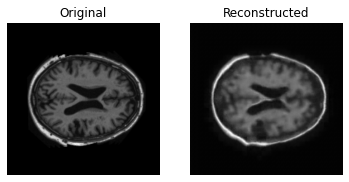

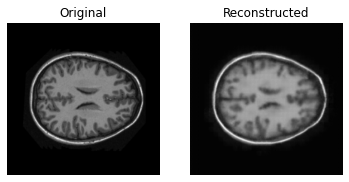

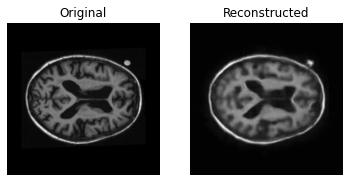

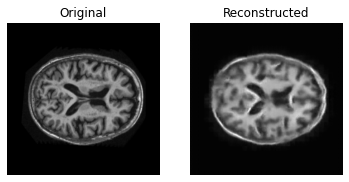

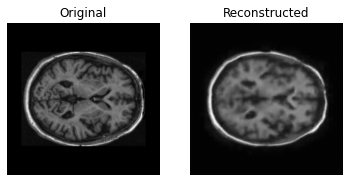

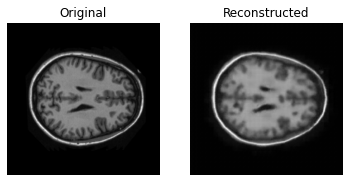

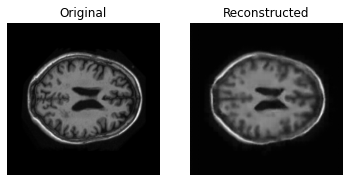

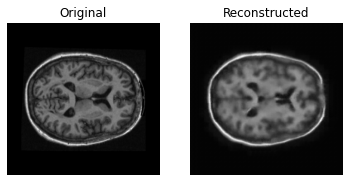

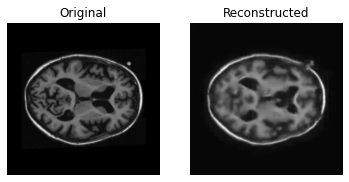

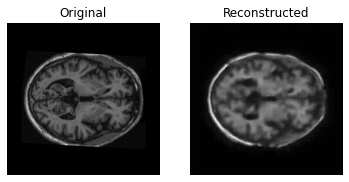

In [9]:
#Taking a look at reconstruction results
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze(),cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze(),cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

trained_vqvae = VQVAE_trainer.vq_vae
idx = np.random.choice(len(X_test), 10)
test_images = X_test[idx]
reconstructions_test = trained_vqvae.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

(10, 32, 32)


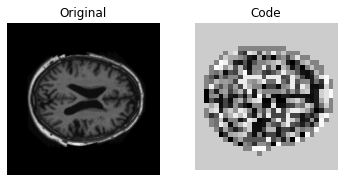

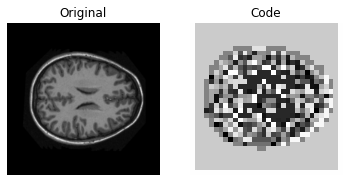

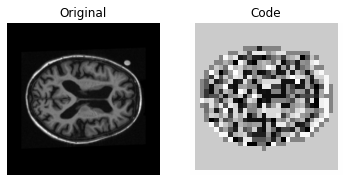

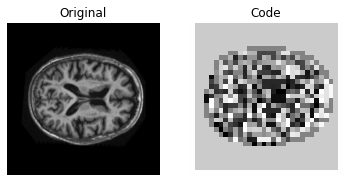

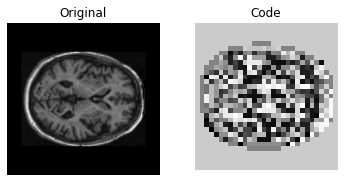

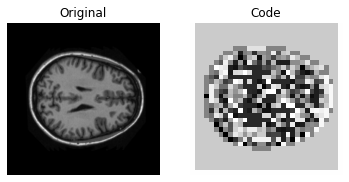

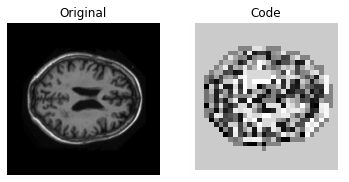

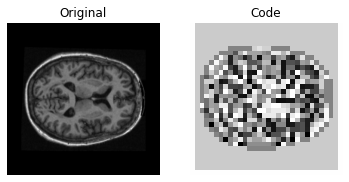

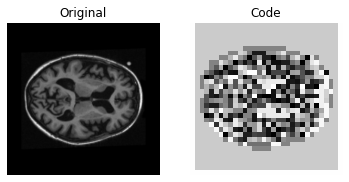

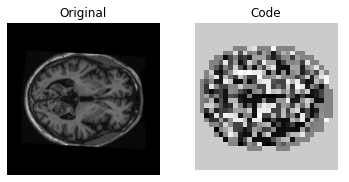

In [10]:
#Let us now have a look at the codes

my_encoder = VQVAE_trainer.vq_vae.get_layer("encoder")
my_quantiser = VQVAE_trainer.vq_vae.get_layer("Quantiser")

encoded_outputs = my_encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = my_quantiser.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

print(codebook_indices.shape)

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze(),cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i],cmap='gray')
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [26]:
#Reconstructing the images in the test set to calculate SSIM
reconstructed_test_images = trained_vqvae.predict(X_test)

from skimage.metrics import structural_similarity as ssim

SSIM=np.zeros(shape=(reconstructed_test_images.shape[0],))

for i in range(len(SSIM)):
    SSIM[i]=ssim(X_test[i,:,:,0],reconstructed_test_images[i,:,:,0])

total_ssim=np.sum(SSIM)
mean_ssim = total_ssim/X_test.shape[0]

print("The mean SSIM on the test dataset is",mean_ssim)

<ipython-input-26-d5c350ca123d>:9: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  SSIM[i]=ssim(X_test[i,:,:,0],reconstructed_test_images[i,:,:,0])


The mean SSIM on the test dataset is 0.8682193400121998


In [102]:
#Let's try to generate images with the codes using a PixelCNN

#Defining the hyperparameters first
n_residual_blocks = 16
n_pixelcnn_layers = 16
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (32, 32)


In [139]:
class PixelCNNLayer(layers.Layer):
    
    def __init__(self,mask_type,**kwargs):
        super(PixelCNNLayer,self).__init__()
        self.mask_type = mask_type
        self.conv_layer = layers.Conv2D(**kwargs)
        
    def build(self,input_shape):
        self.conv_layer.build(input_shape)
        kernel_shape = self.conv_layer.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[:kernel_shape[0]//2,...] = 1.0
        self.mask[kernel_shape[0]//2,:kernel_shape[1]//2,...] = 1.0
        if self.mask_type == 'B':
            self.mask[kernel_shape[0]//2,kernel_shape[1]//2,...] = 1.0
        
    def call(self,inputs):
        self.conv_layer.kernel.assign(self.conv_layer.kernel*self.mask)
        return self.conv_layer(inputs)
    
class ResidualBlock(layers.Layer):
    
    def __init__(self,filters,**kwargs):
        super(ResidualBlock,self).__init__(**kwargs)
        self.conv_layer_1 = layers.Conv2D(filters=filters,kernel_size=1,activation='relu')
        self.pixel_conv_layer = PixelCNNLayer(mask_type='B',
                                             filters=filters//2,
                                             kernel_size=3,
                                             activation='relu',
                                             padding='same')
        self.conv_layer_2 = layers.Conv2D(filters=filters,kernel_size=1,activation='relu')
        
    def call(self,inputs):
        x=self.conv_layer_1(inputs)
        x=self.pixel_conv_layer(x)
        x=self.conv_layer_2(x)
        return layers.add([inputs,x])
    
PixelCNN_inputs = keras.Input(pixelcnn_input_shape,dtype=tf.int32)

one_hot = tf.one_hot(PixelCNN_inputs,VQVAE_trainer.N)

x = PixelCNNLayer(mask_type='A',filters=128,kernel_size=7,activation='relu',padding='same')(one_hot)
for elt in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)
for elt in range(n_pixelcnn_layers):
    x = PixelCNNLayer(mask_type='B',filters=128,kernel_size=1,strides=1,
                     activation='relu',padding='valid')(x)
output_layer = layers.Conv2D(filters=VQVAE_trainer.N,kernel_size=1,strides=1,padding='same')(x)

PixelCNN = keras.Model(PixelCNN_inputs,output_layer,name='PixelCNN')
PixelCNN.summary()

Model: "PixelCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 32, 32)]          0         
_________________________________________________________________
tf.one_hot_23 (TFOpLambda)   (None, 32, 32, 512)       0         
_________________________________________________________________
pixel_cnn_layer_864 (PixelCN (None, 32, 32, 128)       3211392   
_________________________________________________________________
residual_block_421 (Residual (None, 32, 32, 128)       98624     
_________________________________________________________________
residual_block_422 (Residual (None, 32, 32, 128)       98624     
_________________________________________________________________
residual_block_423 (Residual (None, 32, 32, 128)       98624     
_________________________________________________________________
residual_block_424 (Residual (None, 32, 32, 128)       986

In [133]:
new_codebook_indices = np.zeros(shape=(9664,32,32))

#Generating the codebook indices
#Had to do it batch by batch (each containing 64 images)
#hence why the loop goes to 151, because 64x151=9664 which
#is the size of the training set
for i in range(151):
    encoded_output = my_encoder.predict(X_train[64*i:64*(i+1)])
    flat_enc_output = encoded_output.reshape(-1,encoded_output.shape[-1])
    codebook_idx = my_quantiser.get_code_indices(flat_enc_output)
    codebook_idx = codebook_idx.numpy().reshape(encoded_output.shape[:-1])
    new_codebook_indices[64*i:64*(i+1)] = codebook_idx

print(f"Shape of the training data for PixelCNN: {new_codebook_indices.shape}")

Shape of the training data for PixelCNN: (9664, 32, 32)


In [140]:
PixelCNN.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
PixelCNN.fit(
    x=new_codebook_indices,
    y=new_codebook_indices,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
)

PixelCNN.save_weights('PixelCNN')

Epoch 1/100
272/272 [==============================] - 22s 68ms/step - loss: 3.0390 - accuracy: 0.4029 - val_loss: 2.1106 - val_accuracy: 0.4274
Epoch 2/100
272/272 [==============================] - 17s 63ms/step - loss: 1.8637 - accuracy: 0.5029 - val_loss: 1.4495 - val_accuracy: 0.6043
Epoch 3/100
272/272 [==============================] - 17s 63ms/step - loss: 1.3894 - accuracy: 0.6118 - val_loss: 1.2611 - val_accuracy: 0.6377
Epoch 4/100
272/272 [==============================] - 17s 63ms/step - loss: 1.2092 - accuracy: 0.6498 - val_loss: 1.1568 - val_accuracy: 0.6608
Epoch 5/100
272/272 [==============================] - 17s 63ms/step - loss: 1.1336 - accuracy: 0.6664 - val_loss: 1.1205 - val_accuracy: 0.6692
Epoch 6/100
272/272 [==============================] - 17s 63ms/step - loss: 1.0949 - accuracy: 0.6750 - val_loss: 1.0859 - val_accuracy: 0.6776
Epoch 7/100
272/272 [==============================] - 17s 63ms/step - loss: 1.0500 - accuracy: 0.6846 - val_loss: 1.0296 - val_ac

In [141]:
#We can now focus on image generation.
#Below we create a non trained model off the previous pixelCNN
#which will serve for generation

import tensorflow_probability as tfp

pixel_inputs = layers.Input(shape=PixelCNN.input_shape[1:])
x = PixelCNN(pixel_inputs,training=False)
dist = tfp.distributions.Categorical(logits=x)
sampled = dist.sample()
sampler = keras.Model(pixel_inputs,sampled)

In [142]:
#Let's finally generate images

nb_images = 10
priors = np.zeros(shape=(nb_images,)+(PixelCNN.input_shape[1:]))
nb_images, rows, cols = priors.shape

for row in range(rows):
    for col in range(cols):
        probs = sampler.predict(priors)
        priors[:,row,col]=probs[:,row,col]

print(f"Prior shape : {priors.shape}")

Prior shape : (10, 32, 32)


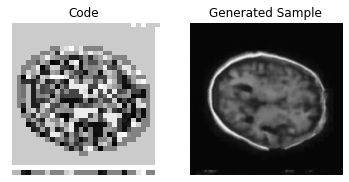

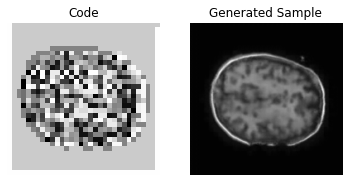

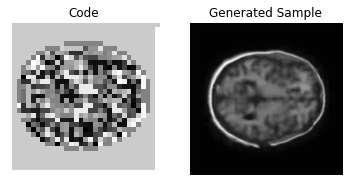

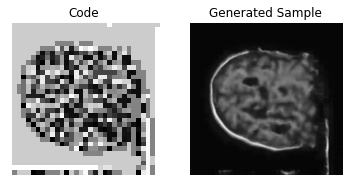

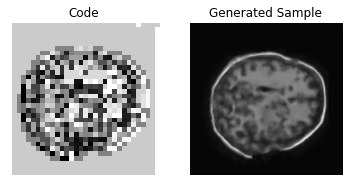

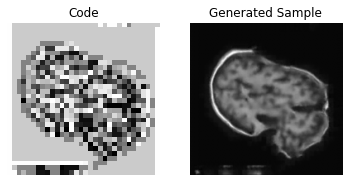

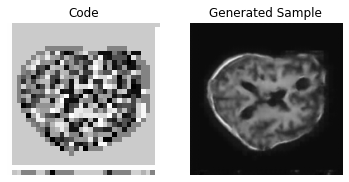

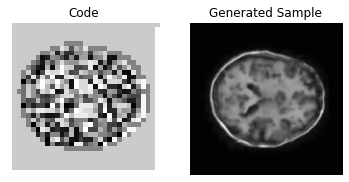

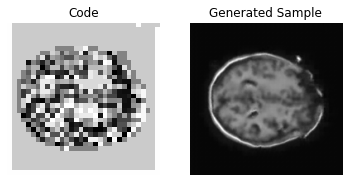

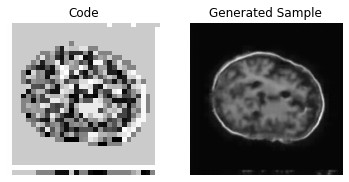

In [143]:
pretrained_embeddings = my_quantiser.codebook
priors_one_hot = tf.one_hot(priors.astype("int32"),VQVAE_trainer.N).numpy()
quantised = tf.matmul(priors_one_hot.astype("float32"),pretrained_embeddings,transpose_b=True)
quantised = tf.reshape(quantised,(-1,*((32,32,128))))

pixel_decoder = VQVAE_trainer.vq_vae.get_layer("decoder")
generated_samples = pixel_decoder.predict(quantised)

for i in range(nb_images):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i],cmap='gray')
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze(),cmap='gray')
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

In [164]:
#Now generating the test codebook indices to generate images off them with the pixel CNN

test_encoded_outputs = my_encoder.predict(X_test)
test_flat_enc_outputs = test_encoded_outputs.reshape(-1,test_encoded_outputs.shape[-1])
test_codebook_indices = my_quantiser.get_code_indices(test_flat_enc_outputs)
test_codebook_indices = test_codebook_indices.numpy().reshape(test_encoded_outputs.shape[:-1])

print(f"Shape of the test data for PixelCNN: {test_codebook_indices.shape}")

Shape of the test data for PixelCNN: (544, 32, 32)


In [167]:
#Onto the actual generation
test_codebook_indices_one_hot = tf.one_hot(test_codebook_indices.astype("int32"),VQVAE_trainer.N).numpy()
test_quantised = tf.matmul(test_codebook_indices_one_hot.astype("float32"),pretrained_embeddings,transpose_b=True)
test_quantised = tf.reshape(test_quantised,(-1,*((32,32,128))))

generated_test_samples = pixel_decoder.predict(test_quantised)
generated_test_samples.shape

(544, 256, 256, 1)

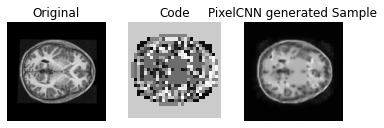

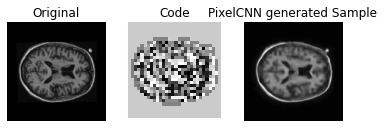

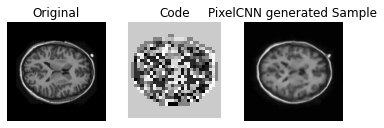

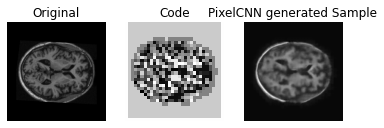

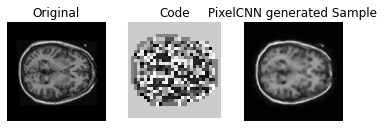

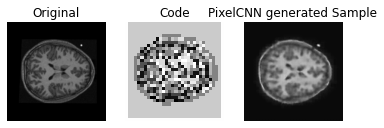

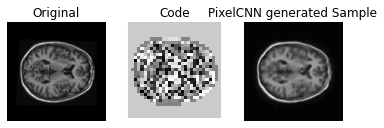

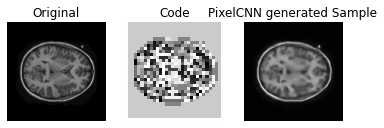

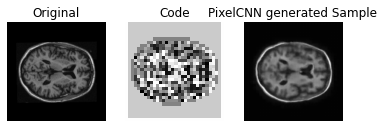

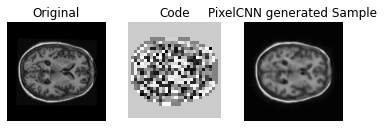

In [171]:
#Little visualisation of a random 10 images
test_idx = np.random.choice(len(X_test), 10)
for i in range(len(test_idx)):
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[test_idx[i]],cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(test_codebook_indices[test_idx[i]],cmap='gray')
    plt.title("Code")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(generated_test_samples[test_idx[i]].squeeze(),cmap='gray')
    plt.title("PixelCNN generated Sample")
    plt.axis("off")
    plt.show()

In [172]:
test_SSIM=np.zeros(shape=(X_test.shape[0],))

for i in range(len(test_SSIM)):
    test_SSIM[i]=ssim(X_test[i,:,:,0],generated_test_samples[i,:,:,0])

test_total_ssim=np.sum(test_SSIM)
test_mean_ssim = test_total_ssim/X_test.shape[0]

print("The mean SSIM on the test dataset is",test_mean_ssim)

<ipython-input-172-6cb974e955ef>:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  test_SSIM[i]=ssim(X_test[i,:,:,0],generated_test_samples[i,:,:,0])


The mean SSIM on the test dataset is 0.8682193400545757


In [173]:
!pip show tensorflow-probability

Name: tensorflow-probability
Version: 0.12.1
Summary: Probabilistic modeling and statistical inference in TensorFlow
Home-page: http://github.com/tensorflow/probability
Author: Google LLC
Author-email: no-reply@google.com
License: Apache 2.0
Location: /opt/conda/envs/saturn/lib/python3.9/site-packages
Requires: cloudpickle, six, decorator, numpy, dm-tree, gast
Required-by: 
